<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-TF-enrichments-for-top-20-genes-in-each-component" data-toc-modified-id="Get-TF-enrichments-for-top-20-genes-in-each-component-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get TF enrichments for top 20 genes in each component</a></span></li><li><span><a href="#Sensitivity-Analysis" data-toc-modified-id="Sensitivity-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sensitivity Analysis</a></span></li></ul></div>

In [1]:
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
sys.path.append('..')
from icaviz.load import *

In [3]:
DATA_DIR = '../data/precise_data/'
GENE_DIR = '../data/annotation/'
X_file = DATA_DIR + 'log_tpm.csv'
S_file = DATA_DIR + 'S.csv'
A_file = DATA_DIR + 'A.csv'
metadata_file = DATA_DIR+'metadata.csv'
annotation_file = GENE_DIR + 'gene_info.csv'
trn_file = GENE_DIR + 'TRN.csv'

In [4]:
# Load ica_data object    
ica_data = load_data(X_file,S_file,A_file,
                     metadata_file,annotation_file,
                     trn_file)

# Get TF enrichments for top 20 genes in each component
The mean number of genes in an *E. coli* regulon is 30, and the median is 6.

In [7]:
# Some versions of pandas activate an internal FutureWarning, so we will quiet those

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

In [8]:
# Initialize objects
list2struct = []

all_genes = set(ica_data.S.index)

for k in tqdm(ica_data.S.columns):
    # Get top 20 genes
    genes = set(abs(ica_data.S[k]).sort_values().iloc[-20:].index)

    # Compute single TF enrichments
    enrichments = compute_enrichments(genes, all_genes, 
                                      ica_data.trn, max_tfs=1, 
                                      fdr_rate=1e-5)
    enrichments['TF'] = enrichments.index
    enrichments['component'] = k
    enrichments['n_genes'] = len(genes)

    list2struct.append(enrichments.reset_index(drop=True))
    
DF_enriched = pd.concat(list2struct, sort=False).reset_index(drop=True)
DF_enriched = DF_enriched[['component', 'TF', 'log_odds', 
                           'pvalue', 'qvalue','precision',
                           'recall','f1score','TP', 'n_genes','n_tf']]
    
# Sort by p-value
DF_enriched = DF_enriched.sort_values(['component','qvalue']).drop_duplicates('component')
DF_enriched = DF_enriched.set_index('component')
DF_enriched.head()

,TF,log_odds,pvalue,qvalue,precision,recall,f1score,TP,n_genes,n_tf
component,,,,,,,,,,
1,glpR,inf,2.795068e-22,7.323078e-20,0.45,1.000000,0.620690,9.0,20,1.0
5,mhpR,6.189547,7.327331e-09,1.919761e-06,0.20,0.666667,0.307692,4.0,20,1.0
6,betI,inf,4.916955e-10,1.288242e-07,0.20,1.000000,0.333333,4.0,20,1.0
7,mlc,5.560169,4.978526e-10,1.304374e-07,0.25,0.500000,0.333333,5.0,20,1.0
8,argR,4.397126,1.393148e-17,3.650048e-15,0.70,0.113821,0.195804,14.0,20,1.0


In [9]:
print('Total components:',len(ica_data.S.columns))
print('Components with regulator enrichments:',len(DF_enriched))
print('Unique regulators:',len(DF_enriched.TF.unique()))

Total components: 92
Components with regulator enrichments: 61
Unique regulators: 55


# Sensitivity Analysis
To identify the best cutoff, we can scan across various cutoffs to identify the best results. 

In [10]:
precision = []
recall = []
fpr = []
f1_score = []
all_genes = set(ica_data.S.index)
vals = np.arange(200,1000,50)

for cutoff in tqdm(vals):
    prec = []
    rec = []
    f1_i = []
    fpr_i = []

    for i,row in DF_enriched.iterrows():
        
        # Get threshold based on test-statistic cutoff
        thresh = compute_threshold(ica_data.S,i,cutoff)
        
        # Get genes in i-modulon
        ic_genes = set(ica_data.S[abs(ica_data.S[i]) > thresh].index)
        
        # Get genes in linked regulon
        reg_genes = set(ica_data.trn[ica_data.trn.TF == row.TF].gene_id)
        
        # Compute contingency table
        ((tp_i,fp_i),(fn_i,tn_i)) = contingency(reg_genes,ic_genes,all_genes)

        # Calculate metrics for one regulator-component pair
        prec_tmp = np.true_divide(tp_i,tp_i+fp_i)
        rec_tmp = np.true_divide(tp_i,tp_i+fn_i)
        f1_tmp = (2*prec_tmp*rec_tmp)/(prec_tmp+rec_tmp) if prec_tmp + rec_tmp > 0 else 0
        fpr_tmp = np.true_divide(fp_i,fp_i+tn_i)

        # Add to list for this cutoff score
        prec.append(prec_tmp)
        rec.append(rec_tmp)
        f1_i.append(f1_tmp)
        fpr_i.append(fpr_tmp)

    # Get mean of metric for this cutoff score
    precision.append(np.mean(prec))
    recall.append(np.mean(rec))
    fpr.append(np.mean(fpr_i))
    f1_score.append(np.mean(f1_i))

The [F1-score](https://en.wikipedia.org/wiki/F1_score) measures the balance between [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall).

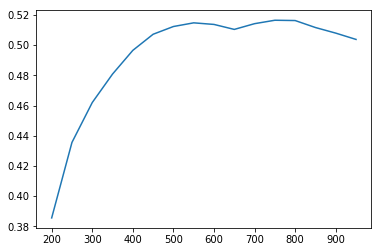

In [11]:
plt.plot(vals,f1_score)

In [12]:
print('Max F1-score:',max(f1_score))
print('Cutoff value:',vals[np.argmax(f1_score)])

Max F1-score: 0.5164865524795197
Cutoff value: 750


Text(0.5, 1.0, 'ROC Curve')

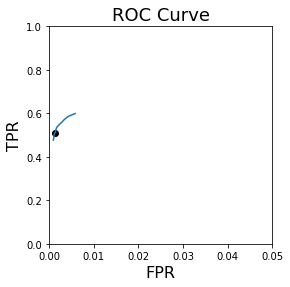

In [16]:
fig,ax = plt.subplots(figsize=(4,4))
plt.plot(fpr,recall)
plt.xlabel('FPR',fontsize=16)
plt.ylabel('TPR',fontsize=16)
plt.scatter([fpr[np.argmax(f1_score)]],[recall[np.argmax(f1_score)]],color='k')
plt.xlim([0,0.05])
plt.ylim([0,1])
plt.title('ROC Curve',fontsize=18)

Text(0.5, 1.0, 'Precision-Recall Curve')

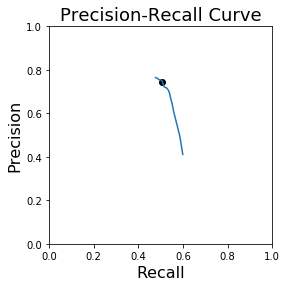

In [17]:
fig,ax = plt.subplots(figsize=(4,4))
plt.plot(recall,precision)
plt.xlabel('Recall',fontsize=16)
plt.ylabel('Precision',fontsize=16)
plt.scatter([recall[np.argmax(f1_score)]],[precision[np.argmax(f1_score)]],color='k')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Precision-Recall Curve',fontsize=18)